# DATA20001 Deep Learning - Group Project
## Text project

**Due Thursday, May 20, before 23:59.**

The task is to learn to assign the correct labels to news articles.  The corpus contains ~850K articles from Reuters.  The test set is about 10% of the articles. The data is unextracted in XML files.

We're only giving you the code for downloading the data, and how to save the final model. The rest you'll have to do yourselves.

Some comments and hints particular to the project:

- One document may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are documents that don't belong to any class, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.
- You may use word-embeddings to get better results. For example, you were already using a smaller version of the GloVE  embeddings in exercise 4. Do note that these embeddings take a lot of memory. 
- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [1]:
# installing PIL (neccessary when using google colab)
#!pip install --no-cache-dir -I pillow

     |████████████████████████████████| 2.1MB 4.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [1]:
pip install torchvision

In [2]:
pip install pytorch-nlp

     |████████████████████████████████| 92kB 3.8MB/s 


In [3]:
import sys
import os
from os.path import exists
import zipfile
import gc
import pickle

# text handling
from bs4 import BeautifulSoup as bs
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# dataframes
import pandas as pd
import numpy as np

# visualization
import seaborn as sns

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset, DataLoader
from torchnlp.encoders.text import StaticTokenizerEncoder,stack_and_pad_tensors, pad_tensor

# torchvision
import torchvision
from torchvision.datasets.utils import download_url


#TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# sklearn & matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
#%matplotlib inline

# wheel
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
torch.cuda
print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [0]:
cuda0 = torch.device('cuda:0') # test set GPU to respond to device name cuda0

In [6]:
accelerator

'cu101'

## Get the data

In [0]:
root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)

In [0]:
# importing the data
train_path = 'train'
dl_file = 'reuters-training-corpus.zip'
dl_url = 'https://www.cs.helsinki.fi/u/yangarbe/Courses/2020-deep-learning/text-training-corpus/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)

In [0]:
# importing the topic codes
text_project_path = 'text-project'
dl_file = 'topic_codes.txt'
dl_url = 'https://www.cs.helsinki.fi/u/yangarbe/Courses/2020-deep-learning/text-project/'

topic_codes_path = os.path.join(text_project_path, dl_file)
#text_project_path
if not os.path.isfile(topic_codes_path):
    download_url(dl_url + dl_file, root=text_project_path, filename=dl_file, md5=None)
    

In [0]:
DATA_FOLDER_DIR = os.path.abspath(os.path.join(root_dir, text_project_path))

topic_codes_location = os.path.join(text_project_path, dl_file)

# from get_data.py
def get_codes(codefile):
    codes = {}
    i = 0
    with open(codefile, 'r') as cf:
        for line in cf:
            if not line.startswith(';'):
                code = line.strip().split('\t')[0]
                codes[code] = i
                i += 1
    return codes

CODEMAP = get_codes(topic_codes_location)
CODEMAP_list = (list(CODEMAP.keys()))

In [0]:
train_path = os.path.abspath(os.path.join(root_dir, train_path))
reuters_unzipped_path = os.path.abspath(os.path.join(train_path, 'REUTERS_CORPUS_2'))

zipped_news_files = os.listdir(os.path.abspath(reuters_unzipped_path))
print(len(zipped_news_files))
zipped_news_files = [x for x in zipped_news_files if "1" in x]
print(len(zipped_news_files))

130
127


In [0]:
rows_list = []

In [0]:
%%time


pattern = r'"([A-Za-z0-9_\./\\-]*)"'

for news_file in zipped_news_files:
    zf = zipfile.ZipFile(os.path.abspath(os.path.join(reuters_unzipped_path, news_file)), 'r')
    for name in zf.namelist():
        dict1 = {} # saving into dicts which are then saved into a list which is then saved into the df.
        f = zf.open(name).read()
        soup = bs(f, "lxml")
        
        #title = soup.title.text
        dict1["title"] = soup.title.text
        dict1["text"] = soup.find("text").text
        codes = []
        metadata_codes = soup.metadata.find_all("code")
        
        for val in metadata_codes:
            m = re.search(pattern, str(val))
            codes.append(m.group().replace('"', ''))
        
        dict1["codes"] = [value for value in codes if value in CODEMAP_list] # remove unnecessary codes
        
        rows_list.append(dict1)
    break # remove break for full dataframe



shape: (2928, 3)
CPU times: user 6.83 s, sys: 0 ns, total: 6.83 s
Wall time: 6.83 s


Use this code to load dataset from text file. Text file is a list of dictionary(faster way to load data)

In [0]:
list_file = '/content/cleaned_text_data.txt'

In [0]:
#Read list from file


# open file and read the content in a list
with open(list_file, 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace =ast.literal_eval(line[:-1])

        # add item to the list
        rows_list.append(currentPlace)

In [0]:
df = pd.DataFrame(rows_list, columns=['title', 'text', 'codes'])
print('shape:', df.shape)

In [0]:
#Check out the dataframe
df.head()

,title,text,codes
0,EU: Reuter EC Report Long-Term Diary for July ...,\n****\nHIGHLIGHTS\n****\nMADRID - NATO holds ...,"[G15, GCAT]"
1,EU: Official Journal contents - OJ C 199 of Ju...,\n*\n(Note - contents are displayed in reverse...,"[G15, GCAT]"
2,EU: Official Journal contents - OJ L 172 of Ju...,\n*\nCOUNCIL REGULATION (EC) No 1186/97 of 27 ...,"[G15, GCAT]"
3,EU: Official Journal contents - OJ L 171 of Ju...,\n*\n(Note - contents are displayed in reverse...,"[G15, GCAT]"
4,EU: Official Journal contents - OJ C 201 of Ju...,\n*\n(Note - contents are displayed in reverse...,"[G15, GCAT]"


In [0]:
#inspect the text content
df.loc[1]["text"]

"\n*\n(Note - contents are displayed in reverse order to that in the printed Journal)\n*\nRemoval from the register of T-8/96 (1) (97/C 199/95)\nRemoval from the register of T-115/95 (1) (97/C 199/94)\nRemoval from the register of T-300/94 (1) (97/C 199/93)\nRemoval from the register of T-259/94 (1) (97/C 199/92)\nAction brought on 5 May 1997 by David T. Keeling against the Office for Harmonization in the Internal Market (Trade Marks and Designs) (Case T-148/97) (97/C 199/91)\nAction brought on 30 April 1997 by Champion Stationery Mfg Co. Ltd., Sun Kwong Metal Manufacturer Co. Ltd and US Ring Binder Corporation against the Council of the European Union (Case T-147/97) (97/C 199/90)\nAction brought on 30 April 1997 by J. M. M. Bakkers against the Council of the European Union and the Commission of the European Communities (Case T-146/97) (97/C 199/89)\nAction brought on 29 April 1997 by J. P. W. Vrencken against the European Community (Case T-145/97) (97/C 199/88)\nAction brought on 29 

In [0]:
def display_Codes(df):
    codes = df["codes"].values  #Get the Codes from the dataframe
    
    #Convert the list of lists to a single list
    code_list= []
    for sublist in codes:
        for item in sublist:
            code_list.append(item)
            
    #Get unique codes from the list        
    code_list_unique = np.array(code_list)
    print("Unique number of codes: ", len(np.unique(code_list_unique)))
    
    
    #Count the frequency of codes in the list
    code_freq = nltk.FreqDist(code_list)
    
    code_freq_df = pd.DataFrame({'Code': list(code_freq.keys()), 
                              'Count': list(code_freq.values())})
    
    #Convert the count to a dataframe and plot codes with more than 50 counts
    g = code_freq_df.nlargest(columns="Count", n=50)
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=g, x= "Count", y = "Code") 
    ax.set(ylabel = 'Count') 
    plt.show()

Unique number of codes:  96


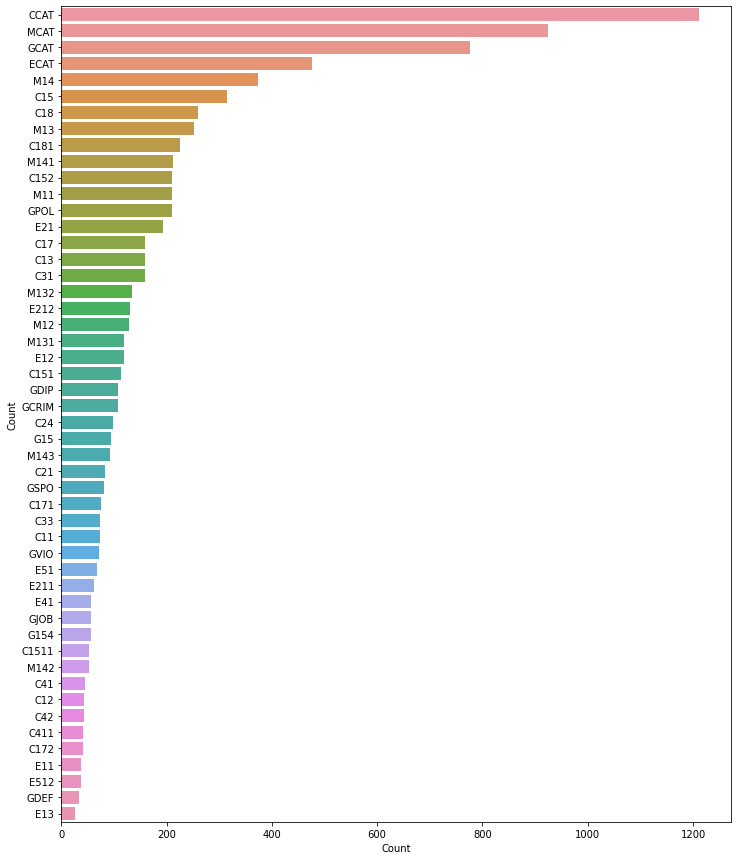

In [0]:
display_Codes(df)

In [0]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\n'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [0]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
lemmatizer = WordNetLemmatizer() 

def lemmatize(words):
    lemmatized_text = [lemmatizer.lemmatize(t, pos='n') for t in words] # lemmatized nouns
    return ''.join(lemmatized_text)

In [0]:
def implement_clean_text(df):
    df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
    df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopwords(x))
    df['clean_text'] = df['clean_text'].apply(lambda x: lemmatize(x))
    return df

In [0]:
df = implement_clean_text(df)

In [0]:
#inspect column
df.loc[1]["clean_text"]

'note contents displayed reverse order printed journal removal register c removal register c removal register c removal register c action brought may david keeling office harmonization internal market trade marks designs case c action brought april champion stationery mfg co ltd sun kwong metal manufacturer co ltd us ring binder corporation council european union case c action brought april j bakkers council european union commission european communities case c action brought april j p w vrencken european community case c action brought april c de keijzer european community case c action brought april g van den berg european community case c action brought april eugenio branco lda commission european communities case c action brought april kesko oy commission european communities case c action brought april michael collins committee regions european union case c action brought april nuova sidercamuna spa liquidation commission european communities case c action brought april coca cola 

In [0]:
def create_encoder(data, input_column="clean_text", output_column="codes", X_encoder_filename = 'X_encoder.pickle', Y_encoder_filename='Y_encoder.pickle'):
    
    #initialize tokenizer
    tokenizer = Tokenizer()
    
    #Tokennize clean_text dataseries
    X_token = (data[input_column].astype("str"))
    tokenizer.fit_on_texts(X_token)
    
    #Initialize multilabelbinarizer for encoding codes in one hot
    multilabel_binarizer = MultiLabelBinarizer()
    multilabel_binarizer.fit(data[output_column])
    
    #Save encoders to pickle
    with open(X_encoder_filename, 'wb') as handle:
        pickle.dump(tokenizer, handle)
    with open(Y_encoder_filename, 'wb') as handle:
        pickle.dump(multilabel_binarizer, handle)
    
    return tokenizer, multilabel_binarizer

In [0]:
def tokenize_data(data,X_encoder, Y_encoder,input_column="clean_text", output_column="codes"):
    #Convert cleaned text dataseries to token
    X_raw= X_encoder.texts_to_sequences(df[input_column].astype("str"))
    #Pad text sequence to max of 1000 tokens. This was done so as most of the text had <1000 token
    X_raw= np.array(pad_sequences(X_raw, maxlen=1000, padding= 'pre'))
    
    #transform code dataseries
    y_raw = Y_encoder.transform(data[output_column])
    
    return X_raw, y_raw

In [0]:
def load_encoder(X_encoder_filename = 'X_encoder.pickle', Y_encoder_filename='Y_encoder.pickle'):
    with open (X_encoder_filename, 'rb') as handle:
        X_encoder = pickle.load(handle)
    
    with open(Y_encoder_filename, 'rb') as handle:
        Y_encoder = pickle.load(handle)
    
    return X_encoder, Y_encoder

In [0]:
use_preexisting_x_encoder = False
use_preexisting_y_encoder = False

In [0]:
if (use_preexisting_x_encoder and use_preexisting_y_encoder):
    x_encoder, y_encoder = load_encoder()
else:
    x_encoder, y_encoder = create_encoder(data=df)

In [0]:
x_input, y_input = tokenize_data(df, x_encoder, y_encoder)

In [0]:
X_train,X_valid, y_train, y_valid = train_test_split(x_input, y_input, test_size=0.2) 

In [0]:
class createDataset(Dataset):
    def __init__(self, X,Y):
        self.X = X
        self.y=Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return  torch.from_numpy(self.X[idx][0]).long(), torch.from_numpy(self.y[idx]).long()

In [0]:
train_ds = createDataset(X_train,y_train)
valid_ds = createDataset(X_valid, y_valid)

In [0]:
train_loader = DataLoader(train_ds, batch_size = 32)
valid_loader = DataLoader(valid_ds, batch_size=32)

In [0]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([100, 1678]) type: torch.LongTensor
y_train: torch.Size([100, 96]) type: torch.LongTensor


In [0]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


In [0]:
class LSTM_Model_rnn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim,output_size):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim,padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim,hidden_dim,bidirectional=True, batch_first=True)       
        self.l1 = torch.nn.Linear(hidden_dim , 250)
        self.l2 = torch.nn.Linear(250, output_size)


    
    def forward(self,x):
        embedded = self.embedding(x)
        _, (last_hidden,state) = self.rnn(embedded)
        hidden_list = last_hidden[-1]
        encoded2 = F.relu(self.l1(hidden_list))
        output = torch.sigmoid(self.l2(encoded2))
        return output

In [0]:
total_words = len(x_encoder.word_index)+1

model_rnn = LSTM_Model_rnn(total_words,100,100,y_raw.shape[1])
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.1)
criterion_rnn = nn.MSELoss()

In [0]:
print(model)

LSTM_Model(
  (embeddings): Embedding(26520, 20, padding_idx=0)
  (lstm): LSTM(20, 20, batch_first=True)
  (linear): Linear(in_features=20, out_features=96, bias=True)
)


In [0]:
def changedata(x):
    return 1*(x>0.5)

In [0]:
model_rnn.to(device)

In [0]:
def train_rnn(epoch,log_interval=100):

 
    model_rnn.train()
    for batch_idx, (data_rnn, target_rnn) in enumerate(train_loader):
          
        data_rnn= data_rnn.to(device)
        target_rnn = target_rnn.to(device)
        target_rnn= target_rnn.float()
        data_rnn = data_rnn.long()
        optimizer_rnn.zero_grad()
        output_rnn = model_rnn(data_rnn)
          
        loss = criterion_rnn(output_rnn, target_rnn)
          
        loss.backward()

        optimizer_rnn.step()     
        #break
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data_rnn), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [0]:
def validate_rnn(loss_vector, f1_score_vector):
    model_rnn.eval()

    val_loss, val_f1 = 0, 0
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        target= target.float()
        data = data.long()
        output = model(data)
        val_loss += criterion(output, target).data.item()
        ouput= changedata(output)
        val_f1 += f1_score(target, ouput, average='micro')
        
        
        
        
    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    f1_score = val_f1 / len(validation_loader.dataset)
    f1_score_vector.append(f1_score)
    
    print('\nValidation set: Average loss: {:.4f}, Average F1 Score: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), f1_score))

In [0]:
%%time
epochs = 1

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train_rnn(epoch)
    validate(lossv, accv)

RuntimeError: ignored

In [0]:
data = torch.from_numpy(X_raw[20].reshape(1,1000)).long().to(device)

In [0]:
output = model_rnn(data)

In [0]:
multilabel_binarizer.inverse_transform(changedata(output).cpu().detach().numpy())

In [0]:
multilabel_binarizer.inverse_transform(y_raw[20].reshape(1,103))

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [0]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You will be asked to return your predictions a separate test set.  These should be returned as a matrix with one row for each test article.  Each row contains a binary prediction for each label, 1 if it's present in the image, and 0 if not. The order of the labels is the order of the label (topic) codes.

An example row could like like this if your system predicts the presense of the second and fourth topic:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0 ...
    
If you have the matrix prepared in `y` you can use the following function to save it to a text file.

np.savetxt('results.txt', y, fmt='%d')